In [1]:
# Importing relevant libraries

import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython import display
from numpy import expand_dims, zeros, ones
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout 

## Dataset

In [2]:
# data from: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
# code from: https://www.tensorflow.org/tutorials/generative/dcgan

data = pd.read_csv('./fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [4]:
num_classes = 7
img_width = 48
img_height = 48

In [5]:
data.shape

(35887, 3)

In [6]:
X = data['pixels']
y = data['emotion']

In [7]:
X_train = []
for i in X:
    X_train.append([int(j) for j in i.split()])

X_train = np.array(X_train)/255.0

In [8]:
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
X_train = X_train.astype('float32')

In [9]:
X_train.shape

(35887, 48, 48, 1)

In [ ]:
# BUFFER_SIZE = 60000
# BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
#train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Discriminator Model

In [10]:
# define the standalone discriminator model
def define_discriminator(in_shape=(48,48,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Generator Model

In [11]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 12x12 image
    n_nodes = 128 * 12 * 12
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((12, 12, 128)))
    # upsample to 24x24
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 48x48
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (12, 12), activation='tanh', padding='same'))
    return model

In [12]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [13]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [14]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [15]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

In [18]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
    start = time.time()
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss on this epoch
		#print('Time for epoch {} is {} sec d1={}, d2={}, g={}'.format(i + 1, time.time() - start, d_loss1, d_loss2, g_loss))
    print('Time for epoch %d: %.3f sec d1=%.3f d2=%.3f g=%.3f' % (i + 1, time.time() - start, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')

In [19]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = X_train
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Time for epoch 1 is 0.14087605476379395 sec d1=0.6117143034934998, d2=0.7783929109573364, g=0.6320418119430542
Time for epoch 2 is 0.14034795761108398 sec d1=0.6999088525772095, d2=0.6914576292037964, g=0.701718807220459
Time for epoch 3 is 0.1446678638458252 sec d1=0.6950371265411377, d2=0.6939884424209595, g=0.6970106959342957
Time for epoch 4 is 0.14343523979187012 sec d1=0.6897159814834595, d2=0.699286699295044, g=0.6918249130249023
Time for epoch 5 is 0.1455085277557373 sec d1=0.6996382474899292, d2=0.6904398798942566, g=0.6975921392440796
Time for epoch 6 is 0.14499425888061523 sec d1=0.6977068185806274, d2=0.6892273426055908, g=0.7031652927398682
Time for epoch 7 is 0.14883112907409668 sec d1=0.6997402906417847, d2=0.6890703439712524, g=0.7003732919692993
Time for epoch 8 is 0.14979863166809082 sec d1=0.6934822797775269, d2=0.6894676089286804, g=0.7003471851348877
Time for epoch 9 is 0.14416217803955078 sec d1=0.6925143599510193, d2=0.6909269690513611, g=0.698248028755188
Time f

In [20]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

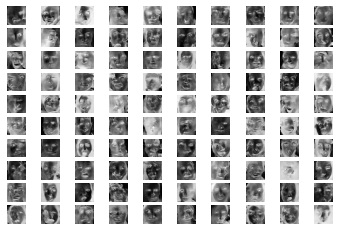

In [21]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)